<a href="https://colab.research.google.com/github/Arrion-Jhiolionton/web2/blob/main/augement302pfinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from google.colab import files
import zipfile
import os

# Upload Image ZIP file
print("📤 Please upload your IMAGE ZIP file...")
uploaded_zip = files.upload()
zip_filename = list(uploaded_zip.keys())[0]
print(f"✅ Uploaded ZIP: {zip_filename}")

# Extract images
print(f"📦 Extracting {zip_filename}...")
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall('dataset/images')
print("✅ Images extracted!")

# Upload JSON file
print("\n📤 Please upload your JSON annotation file...")
uploaded_json = files.upload()
json_filename = list(uploaded_json.keys())[0]
print(f"✅ Uploaded JSON: {json_filename}")

# Move JSON to dataset folder
os.makedirs('dataset', exist_ok=True)
os.rename(json_filename, f'dataset/{json_filename}')
print(f"✅ JSON moved to dataset/{json_filename}")

# Show contents
print("\n📁 Dataset structure:")
print(f"Images: {len(os.listdir('dataset/images'))} files")
print(f"JSON: dataset/{json_filename}")

📤 Please upload your IMAGE ZIP file...


Saving images.zip to images.zip
✅ Uploaded ZIP: images.zip
📦 Extracting images.zip...
✅ Images extracted!

📤 Please upload your JSON annotation file...


Saving prescription_labeling.json to prescription_labeling.json
✅ Uploaded JSON: prescription_labeling.json
✅ JSON moved to dataset/prescription_labeling.json

📁 Dataset structure:
Images: 1 files
JSON: dataset/prescription_labeling.json


In [8]:
# Install albumentations
!pip install -q --upgrade albumentations opencv-python

print("✅ All libraries installed!")

✅ All libraries installed!


In [9]:
import os
import json
from pathlib import Path

# Check dataset structure
dataset_path = Path('dataset')

# Find JSON file
json_files = list(dataset_path.glob('*.json'))
print(f"📄 JSON files found: {len(json_files)}")
for jf in json_files:
    print(f"  - {jf.name}")

# Find images
images_base_path = dataset_path / 'images'
# Check if there's a single subdirectory and adjust images_path
if images_base_path.exists() and len(os.listdir(images_base_path)) == 1:
    first_item = os.listdir(images_base_path)[0]
    if (images_base_path / first_item).is_dir():
        images_path = images_base_path / first_item
        print(f"\nDetected subdirectory: {images_path}. Searching for images there.")
    else:
        images_path = images_base_path
        print(f"\nNo subdirectory detected. Searching for images in: {images_path}.")
else:
    images_path = images_base_path
    print(f"\nSearching for images in: {images_path}.")

# Add debugging to see what's actually in the directory where images are expected
print(f"\n🔎 Contents of {images_path}:")
if images_path.exists():
    for item in os.listdir(images_path):
        print(f"  - {item}")
else:
    print(f"  - Directory {images_path} does not exist.")

image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']
images = []
for ext in image_extensions:
    images.extend(list(images_path.glob(ext)))

print(f"\n🖼️  Images found: {len(images)}")

# Load JSON to check
if json_files:
    with open(json_files[0], 'r', encoding='utf-8') as f:
        data = json.load(f)
    print(f"\n✅ JSON contains {len(data)} tasks")
else:
    print("❌ No JSON file found!")

📄 JSON files found: 1
  - prescription_labeling.json

Detected subdirectory: dataset/images/Merge 300. Searching for images there.

🔎 Contents of dataset/images/Merge 300:
  - img_0519.jpg
  - img_1008.jpg
  - img_0608.jpg
  - img_1051.jpg
  - img_0964.jpg
  - img_0072.jpg
  - img_0085.jpg
  - img_1066.jpg
  - img_0604.jpg
  - img_1075.jpg
  - img_0083.jpg
  - img_1027.jpg
  - img_1028.jpg
  - img_0579.jpg
  - img_0999.jpg
  - img_0097.jpg
  - img_0514.jpg
  - img_1093.jpg
  - img_1069.jpg
  - img_0589.jpg
  - img_0972.jpg
  - img_0071.jpg
  - img_0008.jpg
  - img_0010.jpg
  - img_0092.jpg
  - img_0657.jpg
  - img_1019.jpg
  - img_0015.jpg
  - img_1005.jpg
  - img_0693.jpg
  - img_0591.jpg
  - img_0037.jpg
  - img_1021.jpg
  - img_1002.jpg
  - img_0994.jpg
  - img_0045.jpg
  - img_0991.jpg
  - img_1025.jpg
  - img_0058.jpg
  - img_0495.jpg
  - img_0528.jpg
  - img_1086.jpg
  - img_0491.jpg
  - img_0587.jpg
  - img_1046.jpg
  - img_1108.jpg
  - img_0526.jpg
  - img_0021.jpg
  - img_1103

In [10]:
import json
import cv2
import numpy as np
from pathlib import Path
import albumentations as A
from albumentations.core.bbox_utils import BboxParams
import copy
from tqdm.notebook import tqdm  # Progress bar

# ==================== AUGMENTATION CONFIGS ====================
def get_5_augmentation_configs():
    """5টা augmentation configurations"""

    bbox_params = BboxParams(
        format='albumentations',
        label_fields=['class_labels'],
        min_visibility=0.3
    )

    configs = [

    # 1. Brightness & Contrast (safe)
    A.Compose([
        A.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, p=0.8),
    ], bbox_params=bbox_params),

    # 2. Rotation & Scale (very slight)
    A.Compose([
        A.ShiftScaleRotate(
            shift_limit=0.05, scale_limit=0.05, rotate_limit=3,
            border_mode=cv2.BORDER_CONSTANT, value=255, p=0.7
        ),
    ], bbox_params=bbox_params),

    # 3. Blur (light)
    A.Compose([
        A.OneOf([
            A.GaussianBlur(blur_limit=(3, 5), p=1.0),
            A.MotionBlur(blur_limit=3, p=1.0),
        ], p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.4),
    ], bbox_params=bbox_params),

    # 4. Noise & Compression (safe limits)
    A.Compose([
        A.GaussNoise(var_limit=(5, 15), p=0.5),
        A.ImageCompression(quality_lower=90, quality_upper=100, p=0.4),
    ], bbox_params=bbox_params),

    # 5. Combined (reduced)
    A.Compose([
        A.ShiftScaleRotate(shift_limit=0.03, scale_limit=0.04, rotate_limit=2, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, p=0.5),
        A.OneOf([
            A.GaussianBlur(blur_limit=(3, 4), p=1.0),
            A.GaussNoise(var_limit=(5, 12), p=1.0),
        ], p=0.3),
        A.ImageCompression(quality_lower=92, quality_upper=100, p=0.3),
    ], bbox_params=bbox_params),
]


    return configs

# ==================== EXTRACT BOXES ====================
def extract_boxes_from_labelstudio_full(task_item):
    """Label Studio full export format থেকে boxes extract করো"""
    boxes = []
    class_labels = []
    transcriptions = []

    if 'annotations' not in task_item or len(task_item['annotations']) == 0:
        return None

    annotation = task_item['annotations'][0]
    results = annotation['result']

    for result in results:
        if result['type'] == 'rectanglelabels':
            x = result['value']['x'] / 100.0
            y = result['value']['y'] / 100.0
            w = result['value']['width'] / 100.0
            h = result['value']['height'] / 100.0

            # Clip original bounding box coordinates to [0, 1]
            x_min = np.clip(x, 0.0, 1.0)
            y_min = np.clip(y, 0.0, 1.0)
            x_max = np.clip(x + w, 0.0, 1.0)
            y_max = np.clip(y + h, 0.0, 1.0)

            # Ensure width/height are still positive after clipping
            clipped_w = x_max - x_min
            clipped_h = y_max - y_min

            if clipped_w > 0 and clipped_h > 0:
                boxes.append([x_min, y_min, x_max, y_max])
                class_labels.append(result['value']['rectanglelabels'][0])
            else:
                print(f"⚠️  Dropped a bounding box due to excessive clipping in image: {task_item['data']['image']} - {result['value']}")

        elif result['type'] == 'textarea':
            text_content = result['value']['text'][0] if result['value']['text'] else ""
            transcriptions.append(text_content)

    return {
        'boxes': boxes,
        'class_labels': class_labels,
        'transcriptions': transcriptions
    }

# ==================== AUGMENT IMAGE ====================
def augment_image_with_configs(image_path, annotation_data, configs):
    """5টা config apply করো"""

    image = cv2.imread(str(image_path))
    if image is None:
        print(f"⚠️  Could not read image: {image_path}")
        return []

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width = image.shape[:2]

    augmented_samples = []

    for idx, transform in enumerate(configs):
        try:
            transformed = transform(
                image=image,
                bboxes=annotation_data['boxes'],
                class_labels=annotation_data['class_labels']
            )

            # Removed manual clipping here as it was ineffective against internal Albumentations validation
            # Albumentations will now handle clipping/dropping based on its internal logic and min_visibility

            augmented_samples.append({
                'image': transformed['image'],
                'boxes': transformed['bboxes'],
                'class_labels': transformed['class_labels'],
                'transcriptions': annotation_data['transcriptions'],
                'image_shape': (height, width),
                'config_id': idx
            })

        except Exception as e:
            print(f"❌ Augmentation failed for image {image_path.name} with config {idx}: {e}")
            continue

    return augmented_samples

# ==================== CREATE AUGMENTED ANNOTATION ====================
def create_augmented_task(original_task, augmented_data, aug_index, image_name):
    """Augmented image এর জন্য Label Studio task তৈরি করো"""

    new_task = copy.deepcopy(original_task)

    aug_image_name = f"aug{aug_index}_{image_name}"
    new_task['data']['image'] = f"/data/upload/augmented/{aug_image_name}"
    new_task['id'] = f"{original_task['id']}_aug{aug_index}"
    new_task['predictions'] = []

    new_results = []
    orig_height, orig_width = augmented_data['image_shape']

    for i, (box, label) in enumerate(zip(augmented_data['boxes'], augmented_data['class_labels'])):
        x_min, y_min, x_max, y_max = box

        x = x_min * 100
        y = y_min * 100
        width = (x_max - x_min) * 100
        height = (y_max - y_min) * 100

        # Rectangle label
        new_results.append({
            "original_width": orig_width,
            "original_height": orig_height,
            "image_rotation": 0,
            "value": {
                "x": x,
                "y": y,
                "width": width,
                "height": height,
                "rotation": 0,
                "rectanglelabels": [label]
            },
            "id": f"aug{aug_index}_box{i}",
            "from_name": "ner_labels",
            "to_name": "image",
            "type": "rectanglelabels",
            "origin": "augmentation"
        })

        # Transcription
        transcription = augmented_data['transcriptions'][i] if i < len(augmented_data['transcriptions']) else ""
        new_results.append({
            "original_width": orig_width,
            "original_height": orig_height,
            "image_rotation": 0,
            "value": {
                "x": x,
                "y": y,
                "width": width,
                "height": height,
                "rotation": 0,
                "text": [transcription]
            },
            "id": f"aug{aug_index}_text{i}",
            "from_name": "transcription",
            "to_name": "image",
            "type": "textarea",
            "origin": "augmentation"
        })

    new_task['annotations'][0]['result'] = new_results
    new_task['annotations'][0]['result_count'] = len(new_results)

    return new_task

print("✅ All functions loaded!")

✅ All functions loaded!


In [11]:
def augment_dataset_colab(json_path, images_dir, output_dir):
    """Complete augmentation pipeline for Colab"""

    output_dir = Path(output_dir)
    aug_images_dir = output_dir / 'augmented_images'
    aug_images_dir.mkdir(parents=True, exist_ok=True)

    # Load annotations
    print("📂 Loading annotations...")
    with open(json_path, 'r', encoding='utf-8') as f:
        tasks = json.load(f)
    print(f"✅ Loaded {len(tasks)} tasks\n")

    # Get configs
    configs = get_5_augmentation_configs()
    print(f"🎨 Using {len(configs)} augmentation configs\n")

    # Process each task with progress bar
    all_augmented_tasks = []
    stats = {'original': len(tasks), 'augmented': 0, 'failed': 0, 'skipped': 0}

    for task in tqdm(tasks, desc="Processing"):
        image_path_str = task['data']['image']
        image_name = image_path_str.split('/')[-1]

        # Find image in dataset/images directory
        image_path = Path(images_dir) / image_name

        if not image_path.exists():
            stats['failed'] += 1
            continue

        # Extract boxes
        annotation_data = extract_boxes_from_labelstudio_full(task)

        if annotation_data is None or len(annotation_data['boxes']) == 0:
            stats['skipped'] += 1
            continue

        # Augment
        augmented_samples = augment_image_with_configs(
            image_path,
            annotation_data,
            configs
        )

        # Save augmented images and tasks
        for aug_idx, aug_sample in enumerate(augmented_samples):
            aug_image_name = f"aug{aug_idx}_{image_name}"
            aug_image_path = aug_images_dir / aug_image_name

            aug_image_bgr = cv2.cvtColor(aug_sample['image'], cv2.COLOR_RGB2BGR)
            cv2.imwrite(str(aug_image_path), aug_image_bgr)

            aug_task = create_augmented_task(task, aug_sample, aug_idx, image_name)
            all_augmented_tasks.append(aug_task)
            stats['augmented'] += 1

    # Combine and save
    final_tasks = tasks + all_augmented_tasks

    output_json = output_dir / 'augmented_annotations.json'
    with open(output_json, 'w', encoding='utf-8') as f:
        json.dump(final_tasks, f, indent=2, ensure_ascii=False)

    # Summary
    print("\n" + "="*70)
    print("📊 AUGMENTATION COMPLETE")
    print("="*70)
    print(f"Original tasks:       {stats['original']}")
    print(f"Augmented tasks:      {stats['augmented']}")
    print(f"Failed:               {stats['failed']}")
    print(f"Skipped (no boxes):   {stats['skipped']}")
    print(f"Total dataset:        {len(final_tasks)}")
    print(f"Augmentation factor:  {stats['augmented']/max(stats['original']-stats['skipped'],1):.1f}x")
    print("="*70)
    print(f"✅ JSON: {output_json}")
    print(f"✅ Images: {aug_images_dir}/")

    return final_tasks, stats

# Find JSON and images automatically
dataset_path = Path('dataset')
json_files = list(dataset_path.glob('*.json'))

if json_files:
    JSON_PATH = json_files[0]

    # Determine IMAGES_DIR correctly, accounting for potential subdirectories
    images_base_path = dataset_path / 'images'
    if images_base_path.exists() and len(os.listdir(images_base_path)) == 1:
        first_item = os.listdir(images_base_path)[0]
        if (images_base_path / first_item).is_dir():
            IMAGES_DIR = images_base_path / first_item
        else:
            IMAGES_DIR = images_base_path
    else:
        IMAGES_DIR = images_base_path

    OUTPUT_DIR = 'augmented_output'

    print(f"📄 Using JSON: {JSON_PATH}")
    print(f"🖼️  Images from: {IMAGES_DIR}\n")

    # RUN AUGMENTATION
    final_data, stats = augment_dataset_colab(JSON_PATH, IMAGES_DIR, OUTPUT_DIR)

    print("\n🎉 ALL DONE!")
else:
    print("❌ No JSON file found in dataset folder!")

📄 Using JSON: dataset/prescription_labeling.json
🖼️  Images from: dataset/images/Merge 300

📂 Loading annotations...
✅ Loaded 302 tasks

🎨 Using 5 augmentation configs



/usr/local/lib/python3.12/dist-packages/albumentations/core/composition.py:331: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()
/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-3065586802.py:29: UserWarning: Argument(s) 'value' are not valid for transform ShiftScaleRotate
  A.ShiftScaleRotate(
/tmp/ipython-input-3065586802.py:46: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5, 15), p=0.5),
/tmp/ipython-input-3065586802.py:47: UserWarning: Argument(s) 'quality_lower, quality_upper' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=90, quality_upper=100, p=0.4),
/tmp/ipython-input-3065586802.py:56: UserWarning: Argument(s) 'var_limit' are not valid for transform Gauss

Processing:   0%|          | 0/302 [00:00<?, ?it/s]


📊 AUGMENTATION COMPLETE
Original tasks:       302
Augmented tasks:      1510
Failed:               0
Skipped (no boxes):   0
Total dataset:        1812
Augmentation factor:  5.0x
✅ JSON: augmented_output/augmented_annotations.json
✅ Images: augmented_output/augmented_images/

🎉 ALL DONE!


In [12]:
import shutil

# Create ZIP of augmented dataset
print("📦 Creating ZIP file...")
shutil.make_archive('augmented_dataset', 'zip', 'augmented_output')

print("✅ ZIP created: augmented_dataset.zip")
print(f"📊 Size: {os.path.getsize('augmented_dataset.zip') / (1024*1024):.2f} MB")

# Download
print("\n⬇️  Downloading...")
files.download('augmented_dataset.zip')
print("✅ Download started!")

📦 Creating ZIP file...
✅ ZIP created: augmented_dataset.zip
📊 Size: 339.20 MB

⬇️  Downloading...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Download started!


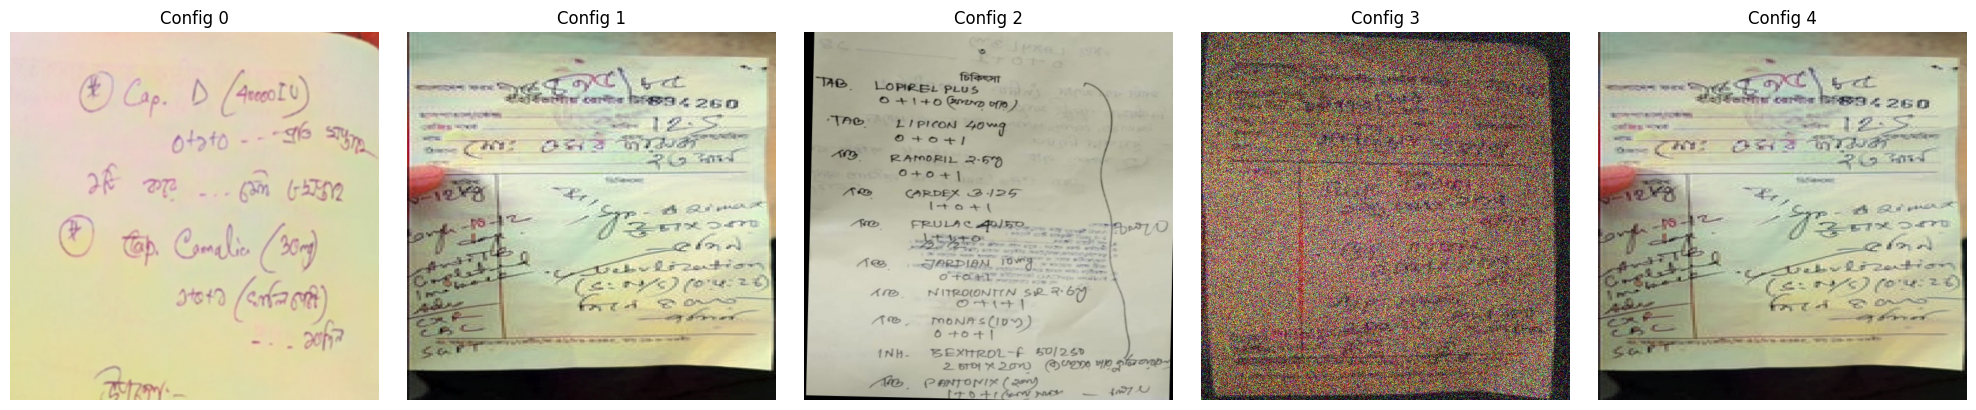

In [13]:
import matplotlib.pyplot as plt
from PIL import Image

# Show original and augmented versions
sample_images = list(Path('augmented_output/augmented_images').glob('aug*'))[:5]

if sample_images:
    fig, axes = plt.subplots(1, len(sample_images), figsize=(20, 4))

    for idx, img_path in enumerate(sample_images):
        img = Image.open(img_path)
        axes[idx].imshow(img)
        axes[idx].set_title(f'Config {idx}')
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No sample images found")